In [1]:
from model import Model
from dmchunk import Chunk
import math
import statistics
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# read data to get experiment intervals
dat = pd.read_csv("dataJS.csv")
# get all discrete values and convert them to seconds (easier for model time keeping!)
sorted_discrete_ts = [time_in_ms/1000 for time_in_ms in sorted(dat.Ts.unique())]
# split into short, medium and long intervals
short_ts = sorted_discrete_ts[:11]
print("- Short durations are: \n{0}".format(short_ts))
med_ts = sorted_discrete_ts[5:16]
print("- Medium durations are: \n{0}".format(med_ts))
long_ts = sorted_discrete_ts[-11:]
print("- Long durations are: \n{0}".format(long_ts))

- Short durations are: 
[0.49409, 0.52938, 0.56467, 0.59996, 0.6352599999999999, 0.67055, 0.70584, 0.74113, 0.77642, 0.81172, 0.84701]
- Medium durations are: 
[0.67055, 0.70584, 0.74113, 0.77642, 0.81172, 0.84701, 0.8823, 0.91759, 0.95288, 0.98818, 1.0235]
- Long durations are: 
[0.84701, 0.8823, 0.91759, 0.95288, 0.98818, 1.0235, 1.0588, 1.0940999999999999, 1.1293, 1.1645999999999999, 1.1999000000000002]


In [31]:
# return sampled time from the given discrete intervals
def sample_time(dur_times):
    t = random.randrange(len(dur_times))
    return dur_times[t]

# helper to add noise 
def noise(s):
#     rand = random.uniform(0.666,0.999)
#     rand = random.uniform(0.333,0.666)
    rand = random.uniform(0.001,0.333)
    return s * math.log((1 - rand)/rand)

# transition from time to pulses (storing)
def time_to_pulses(time, t_0 = 0.011, a = 1.1, b = 0.015, add_noise = True):
    pulses = 0
    pulse_duration = t_0
    while time >= pulse_duration:
        time = time - pulse_duration
        pulses = pulses + 1
        pulse_duration = a * pulse_duration + add_noise * noise(b * a * pulse_duration)
    return pulses

# transition from pulses to time (reproduction)
def pulses_to_time(pulses, t_0 = 0.011, a = 1.1, b = 0.015, add_noise = True):
    time = 0
    pulse_duration = t_0
    while pulses > 0:
        time = time + pulse_duration
        pulses = pulses - 1
        pulse_duration = a * pulse_duration + add_noise * noise(b * a * pulse_duration)
    return time

In [4]:
# alternative scenario in case of failed retrieval
def default_case(ts):
    # choose from normal distribution with mu=ts and sigma=0.25*ts 
    return np.random.normal(ts, ts*0.25, 1)

In [5]:
# one trial of an experiment
def experiment_trial(my_model, ts, trial):
    # transform to pulses with added noise
    tm_pulses = time_to_pulses(ts)
    # store perceived pulses
    chunk = Chunk(name="memory"+str(trial), slots={"type": "perception", "perceived_pulses": tm_pulses})
    my_model.add_encounter(chunk)
    my_model.time += 1.6  # standard time for human response/experiment delays etc. in seconds
    # retrieve with blended retrieval
    blend_pattern = Chunk(name="blend_pattern", slots={"type": "perception"})
    blended_retrieval, latency = my_model.retrieve_blended_trace(blend_pattern, "perceived_pulses")
    # check for failed retieval
    if blended_retrieval == None:
        print("*** FAILED RETRIEVAL ***")
        blended_retrieval = default_case(ts)
    my_model.time += latency  # increment time by latency
    # convert retrieved number of pulses back to time
    tp = pulses_to_time(blended_retrieval)
    # return reproduced time
#     print(">> Initial: {0} || Pulses: {1} || Reproduced: {2}".format(ts, tm_pulses, tp))
    return tp

In [6]:
# an experiment run given the number of test subjects, number of trials and the durations of interest
def experiment(num_subjects, num_trials, dur_times):
    all_ts = []  # all the presented times
    all_tp = []  # all the reproduced times
    # go over all subjects
    for subject in range(num_subjects):
        my_model = Model()  # initialize model for each subject
        # complete the number of trials for each
        for trial in range(num_trials):
            # uniformly random shown time
            ts = sample_time(dur_times)
            # reproduced time
            tp = experiment_trial(my_model, ts, trial)
            # store the values
            all_ts.append(ts)
            all_tp.append(tp)
    return all_ts, all_tp

In [7]:
# perpares data for ploting by averages and variances per discrete interval
def prepare_plot_data(dur_times, all_ts, all_tp):
    print(dur_times)
    all_means = []  # to store all mean tps of given dur_times
    # loop over every duration of the experiment
    for time in dur_times:
        indices = [i for i, x in enumerate(all_ts) if x == time]  # get indices in ts
        all_time_reproductions = [all_tp[i] for i in indices]  # retrieve respective reproduced time
        all_means.append(statistics.mean(all_time_reproductions))  # calculate & store mean
    return all_means

In [8]:
# plotting function
def plot_results(times_dict):
    short_means = prepare_plot_data(short_ts, times_dict['ts_short'][20:], times_dict['tp_short'][20:])
    med_means = prepare_plot_data(med_ts, times_dict['ts_med'][20:], times_dict['tp_med'][20:])
    long_means = prepare_plot_data(long_ts, times_dict['ts_long'][20:], times_dict['tp_long'][20:])
    plt.figure()
    plt.plot([min(short_ts), min(short_ts)], [max(long_ts), max(long_ts)], 'r')
    plt.plot(short_ts, short_means, 'bo')
    plt.plot(med_ts, med_means, 'yo')
    plt.plot(long_ts, long_means, 'ro')
#     plt.plot(times_dict['ts_short'], times_dict['tp_short'], 'bo')
#     plt.plot(times_dict['ts_med'], times_dict['tp_med'], 'yo')
#     plt.plot(times_dict['ts_long'], times_dict['tp_long'], 'ro')
    
    plt.xlabel('Sample Interval (s)')
    plt.ylabel('Production time (s)')

In [16]:
# Running experiment for all three durations and forming the plots
all_ts_short, all_tp_short = experiment(num_subjects=5, num_trials=500, dur_times=short_ts)
all_ts_med, all_tp_med = experiment(num_subjects=5, num_trials=500, dur_times=med_ts)
all_ts_long, all_tp_long = experiment(num_subjects=5, num_trials=500, dur_times=long_ts)
# plot responses after all subjects and trials are complete
all_times_dict = {"ts_short": all_ts_short, "tp_short":all_tp_short,
                  "ts_med": all_ts_med, "tp_med":all_tp_med,
                  "ts_long": all_ts_long, "tp_long":all_tp_long}

[0.49409, 0.52938, 0.56467, 0.59996, 0.6352599999999999, 0.67055, 0.70584, 0.74113, 0.77642, 0.81172, 0.84701]
[0.67055, 0.70584, 0.74113, 0.77642, 0.81172, 0.84701, 0.8823, 0.91759, 0.95288, 0.98818, 1.0235]
[0.84701, 0.8823, 0.91759, 0.95288, 0.98818, 1.0235, 1.0588, 1.0940999999999999, 1.1293, 1.1645999999999999, 1.1999000000000002]


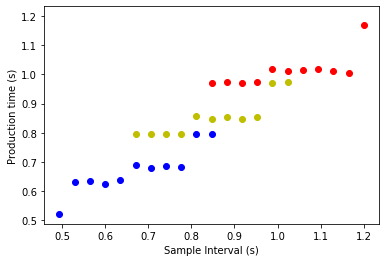

In [17]:
plot_results(all_times_dict)

In [24]:
all_ts_short, all_tp_short = experiment(num_subjects=5, num_trials=500, dur_times=short_ts)

In [30]:
all_ts_med, all_tp_med = experiment(num_subjects=5, num_trials=500, dur_times=med_ts)

In [32]:
all_ts_long, all_tp_long = experiment(num_subjects=5, num_trials=500, dur_times=long_ts)

[0.49409, 0.52938, 0.56467, 0.59996, 0.6352599999999999, 0.67055, 0.70584, 0.74113, 0.77642, 0.81172, 0.84701]
[0.67055, 0.70584, 0.74113, 0.77642, 0.81172, 0.84701, 0.8823, 0.91759, 0.95288, 0.98818, 1.0235]
[0.84701, 0.8823, 0.91759, 0.95288, 0.98818, 1.0235, 1.0588, 1.0940999999999999, 1.1293, 1.1645999999999999, 1.1999000000000002]


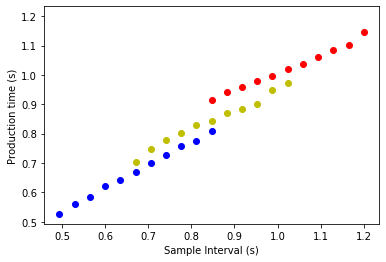

In [33]:
all_times_dict = {"ts_short": all_ts_short, "tp_short":all_tp_short,
                  "ts_med": all_ts_med, "tp_med":all_tp_med,
                  "ts_long": all_ts_long, "tp_long":all_tp_long}
plot_results(all_times_dict)